# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-mitochondrial-proteins" data-toc-modified-id="Effects-of-HIF-1-on-mitochondrial-proteins-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Effects of HIF-1 on mitochondrial proteins</a></div><div class="lev1 toc-item"><a href="#HIF-1-effects-on-the-ribosome" data-toc-modified-id="HIF-1-effects-on-the-ribosome-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>HIF-1 effects on the ribosome</a></div><div class="lev1 toc-item"><a href="#Bioenergetics-of-HIF-1" data-toc-modified-id="Bioenergetics-of-HIF-1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Bioenergetics of HIF-1</a></div><div class="lev1 toc-item"><a href="#Effects-of-HIF-1-on-the-Proteasome-and-Mediator" data-toc-modified-id="Effects-of-HIF-1-on-the-Proteasome-and-Mediator-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Effects of HIF-1 on the Proteasome and Mediator</a></div><div class="lev2 toc-item"><a href="#Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'" data-toc-modified-id="Effect-of-HIF-1-on-proteins-involved-in-'protein-catabolic-process'-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Effect of HIF-1 on proteins involved in 'protein catabolic process'</a></div><div class="lev1 toc-item"><a href="#Proteins-annotated-as-involved-in-protein-folding" data-toc-modified-id="Proteins-annotated-as-involved-in-protein-folding-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Proteins annotated as involved in protein folding</a></div><div class="lev1 toc-item"><a href="#Immune-Involvement" data-toc-modified-id="Immune-Involvement-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Immune Involvement</a></div>

In [1]:
# important stuff:
import os
import pandas as pd
import numpy as np

# morgan
import morgan as morgan

import matplotlib.pyplot as plt
import seaborn as sns

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

import genpy
import seqplotter
import gvars

In [2]:
ft = 35 #title fontsize

q = 0.1

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

sorter = {
          'a' : 4,
          'b' : 1,
          'c' : 3,
          'd' : 2,
          'e' : 0,
          'f' : 5,
          'g' : 6,
         }

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)

In [4]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


In [5]:
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')
central_dogma = pd.read_excel('../input/central_dogma.xlsx')

In [6]:
genvar = gvars.genvars()

In [7]:
tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotype_ontology.csv')
go_df = pd.read_csv('../input/go_dictionary.csv')

NameError: name 'tea' is not defined

In [8]:
melted_tissue = pd.melt(tissue_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_tissue = melted_tissue[melted_tissue.expressed == 1]

melted_phenotype = pd.melt(phenotype_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_phenotype = melted_phenotype[melted_phenotype.expressed == 1]

melted_go = pd.melt(go_df, id_vars='wbid', var_name='term', value_name='expressed')
melted_go = melted_go[melted_go.expressed == 1]

NameError: name 'tissue_df' is not defined

In [9]:
frames = []
for key, df in thomas.beta.items():
    genotype = genvar.fancy_mapping[key]
    df['code'] = key
    df['genotype'] = genotype
    df['sort_order'] = genvar.plot_order[genotype]
    df['abs_b'] = df.b.abs()
    frames += [df]

In [10]:
tidy_data = pd.concat(frames)
tidy_data.sort_values('sort_order', inplace=True)

# drop the fog-2 data:
tidy_data = tidy_data[tidy_data.code != 'g']

# Effects of HIF-1 on mitochondrial proteins

In [ ]:
ax, mito = seqplotter.plot_by_term('mitochondrion', df=tidy_data, kind='go', swarm=True)

# HIF-1 effects on the ribosome

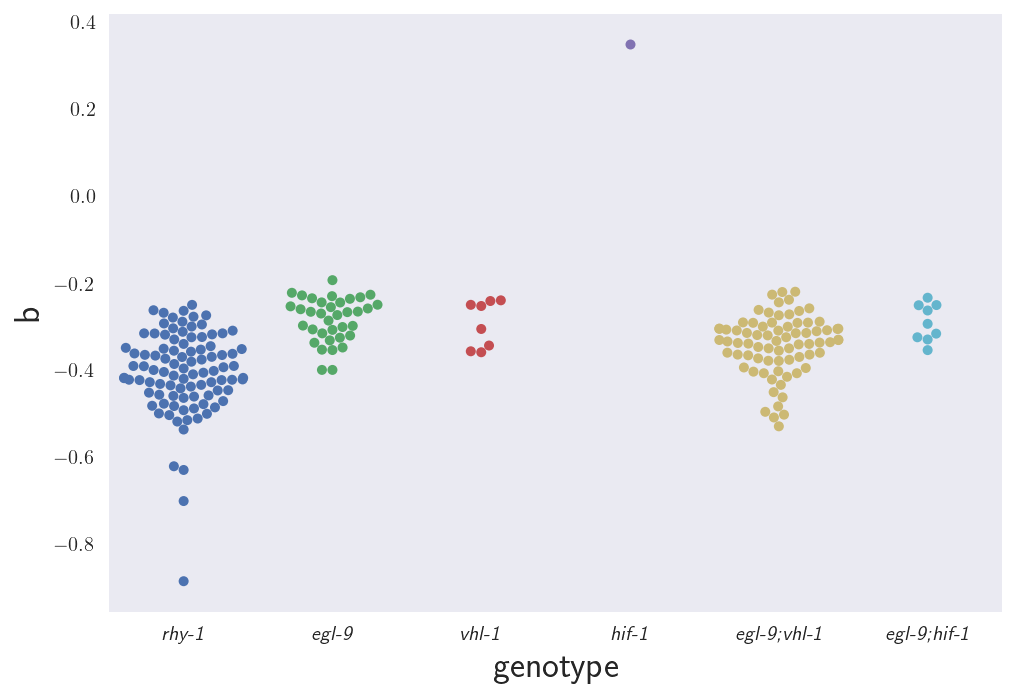

In [11]:
ax, ribosome = seqplotter.plot_by_term('structural constituent of ribosome GO:0003735', df=tidy_data, kind='go')

In [12]:
ribosome

981056    WBGene00004437
981333    WBGene00004421
981462    WBGene00004499
981498    WBGene00022373
981659    WBGene00004490
981698    WBGene00013324
981732    WBGene00021829
981838    WBGene00021920
981937    WBGene00006725
981959    WBGene00004473
982010    WBGene00011740
982018    WBGene00015025
982246    WBGene00004413
982357    WBGene00011309
982410    WBGene00004474
982433    WBGene00017319
982626    WBGene00020718
982690    WBGene00011391
982765    WBGene00010783
982956    WBGene00015133
983027    WBGene00004454
983273    WBGene00044321
983305    WBGene00023422
983307    WBGene00004436
983326    WBGene00010624
983621    WBGene00004423
983680    WBGene00185067
983779    WBGene00012645
983796    WBGene00004416
983960    WBGene00004434
               ...      
991837    WBGene00008452
991862    WBGene00004456
992105    WBGene00023068
992113    WBGene00004495
992193    WBGene00007712
992241    WBGene00004443
992558    WBGene00015487
992579    WBGene00004479
992658    WBGene00004425


# Bioenergetics of HIF-1

In [ ]:
resp = tidy_data[tidy_data.ens_gene.isin(respiratory_complexes.ens_gene) 
                 & (tidy_data.qval < q)
                 & (tidy_data.genotype != 'f') 
                 & ((tidy_data.genotype != 'c'))].copy()
resp['complex'] = resp.ens_gene.map(lambda x: 
                                    respiratory_complexes[respiratory_complexes.ens_gene == x].complex.values[0])
resp['sort_order'] = resp.ens_gene.map(lambda x: 
                                       respiratory_complexes[respiratory_complexes.ens_gene == x].sort_order.values[0])
resp.sort_values('sort_order', inplace=True)
resp = resp[resp.complex != 'Ubiquinone Biosynthesis']

In [ ]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=resp, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
plt.title('HIF-1 mediated bioenergetics changes')
plt.ylabel(r'\beta')
plt.xlabel('TCA, ETC or Energy Reserve')
ax.hlines(0, xmin=-2, xmax=10, lw=2, linestyle='--')
plt.ylim(-4, 1)
plt.savefig('../output/mito_function.pdf')

# Effects of HIF-1 on the Proteasome and Mediator

In [ ]:
prot = tidy_data[tidy_data.ens_gene.isin(central_dogma.ens_gene) &
                 (tidy_data.qval < q)].copy()
prot['complex'] = prot.ens_gene.map(lambda x: central_dogma[central_dogma.ens_gene == x].complex.values[0])

In [ ]:
fig, ax = plt.subplots()
ax = sns.swarmplot(x='complex', y='b', hue='ens_gene', data=prot, size=7)
plt.xticks(rotation=45)
ax.legend_.remove()
# plt.title('HIF-1 mediated changes in ETC expression')
plt.ylabel(r'\beta')
# plt.xlabel('Electron Transport Chain Complexes')

## Effect of HIF-1 on proteins involved in 'protein catabolic process'
This GO term includes proteins that are involved in protein degradation, including the proteasome, a variety of ubiquitin-related enzymes and proteases

In [ ]:
ax, negregproteolysis = plotting.plot_by_term('protein catabolic process GO:0030163',
                                              df=tidy_data, kind='go')

# Proteins annotated as involved in protein folding

In [ ]:
ax, folding = plotting.plot_by_term('protein folding', df=tidy_data, kind='go')

# Immune Involvement

In [ ]:
immune = plotting.plot_by_term('immune system process', df=tidy_data, kind='go')